In [1]:
import sys, os
import torch
import torch.nn as nn
sys.path.append("/home/username/open_clip_original/")
sys.path.insert(0,"/home/username/open_clip_original/src/")
from open_clip import create_model_and_transforms, trace_model, get_tokenizer, create_loss
from training.data import get_data
from training.data import get_data_transformer
from training.distributed import is_master, init_distributed_device, broadcast_object
from training.params import parse_args
from open_clip.transformer import HeadTransformer
import json
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

class MyCosineLoss(nn.Module):

    def __init__(self,reduction='none'):
        super().__init__()
        self.reduction=reduction
        # self._backward_hooks = None
        # self._backward_pre_hooks = None

    def forward(self,x:torch.Tensor,y:torch.Tensor,target:torch.Tensor):
        x_norm = x.norm(2,dim=1)
        y_norm = y.norm(2,dim=1)
        cos = (x * y).sum(dim=-1)
        losses = 1 - cos/x_norm/y_norm
        if self.reduction == 'none':
            return losses
        elif self.reduction == 'mean':
            return losses.mean()

def create_head_transformer(arhitecture=None):
    # loss=torch.nn.CosineEmbeddingLoss(reduction='none')
    loss=MyCosineLoss(reduction='none')
    head=HeadTransformer(layers=arhitecture)
    return head,loss



In [ ]:
sys.path

In [ ]:
key = 'materials'
dataset = 'vamus'
arch = '2'

args = f"""
    --supreme-key {key} \
    --include-context \
    --exp-name {dataset}_{key}_T \
    --group {dataset}_T{arch}_28feb \
    --head-architecture {arch} \
    --lora-rank 32 \
    --lora-alpha 1.0 \
    --lora-dropout 0.0 \
    --save-frequency 2 \
    --report-to wandb \
    --wandb_project_name museum-tabdata-test\
    --dataset-type csv \
    --train-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_train.csv \
    --val-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_val_hala.csv \
    --test-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_test.csv \
    --csv-img-key image_path \
    --csv-caption-key caption \
    --accum-freq 1 \
    --csv-separator , \
    --model ViT-B-32 \
    --pretrained laion2b_s34b_b79k \
    --seed 0 \
    --local-loss \
    --gather-with-grad \
    --warmup 0 \
    --batch-size 1024 \
    --lr 1e-4 \
    --epochs 101 \
    --workers 8 \
    --coca-contrastive-loss-weight 0 \
    --coca-caption-loss-weight 1 \
    --dataset-resampled \
    --lock-text \
    --lock-text-unlocked-layers 13 \
    --lock-image \
    --lock-image-unlocked-groups 5 \
    --precision fp16 \
    --classes /home/username/open_clip/finetuning/dataset_splits/{dataset}_classes.json \
""".replace('\\',"").split()
args = parse_args(args)
init_distributed_device(args)
args

In [3]:
all_captions_to_plot = {}

In [4]:

model_kwargs = {}
device = "cuda"

model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model,
        args.pretrained,
        precision=args.precision,
        device=device,
        jit=args.torchscript,
        force_quick_gelu=args.force_quick_gelu,
        force_custom_text=args.force_custom_text,
        force_patch_dropout=args.force_patch_dropout,
        force_image_size=args.force_image_size,
        image_mean=args.image_mean,
        image_std=args.image_std,
        image_interpolation=args.image_interpolation,
        image_resize_mode=args.image_resize_mode,  # only effective for inference
        aug_cfg=args.aug_cfg,
        pretrained_image=args.pretrained_image,
        output_dict=True,
        **model_kwargs,
    )

tokenizer = get_tokenizer(args.model)
data = get_data_transformer(
    args,
    (preprocess_train, preprocess_val),
    epoch=0,
    tokenizer=tokenizer,
    return_paths=True ##TODO ar trebui args.return_paths
)

In [5]:
maxx_metric=0
arhitecture=args.head_architecture
head,loss=create_head_transformer(arhitecture)
head=head.to(device)


In [6]:
def translate_state_dict(sd):
    return {k.replace('module.',''):v for k,v in sd.items()}

In [ ]:
# import torch.distributed as dist
# os.environ['RANK'] = '0'
# os.environ['WORLD_SIZE'] = '1'
# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '11235'
# dist.init_process_group(backend='gloo')

### Embeddings

In [7]:
f = f"/home/username/open_clip/finetuning/dataset_splits/{dataset}_all_CLIP_embeddings.pt"
# print("f file",f)
if os.path.exists(f):
    all_emb=torch.load(f,map_location=device)


In [8]:
image_emb,text_emb=all_emb["images"],all_emb["texts"]        
classnames = data["classes"] if "classes" in data else None

### Start

In [9]:
all_captions_to_plot.keys()

dict_keys([])

In [10]:
key = 'categories'

In [11]:
head_path = f"/home/username/open_clip/saved_models/final_keys/{key}/2_T_F_head/model.pt"

In [12]:
head_sd = torch.load(head_path,map_location=torch.device(device))

In [13]:
head.load_state_dict(translate_state_dict(head_sd))

<All keys matched successfully>

In [14]:
head_paths = {}
head_sds = {}
for k in classnames:
    head_paths[k] = f"/home/username/open_clip/saved_models/final_keys/{key}/2_T_F_head/model.pt"
    head_sd = torch.load(head_paths[k],map_location=torch.device(device))
    head_sds[k] = translate_state_dict(head_sd)

In [15]:
len(data["val_muse"][key].dataloader)

10

In [16]:
batch = next(iter(data["val_muse"][key].dataloader))

In [17]:
images, texts,paths, attributes, querries, labels = batch
attributes=[json.loads(a) for a in attributes]


In [18]:
args.include_context = True

In [19]:
def create_classifier(key):
    emb_list = []
    for idx, cln in classnames[key].items():
        # emb_list.append((idx, text_emb[cln]))
        emb_list.append((idx, text_emb[cln] / text_emb[cln].norm(2)))
    emb_list.sort(key=lambda x: int(x[0]))
    idx_list, emb_list = zip(*emb_list)
    classifier = torch.stack(emb_list)
    return idx_list, classifier        

In [20]:
idx_list, classifier = create_classifier(key)

In [21]:
batch_inputs=[]
batch_targets=[]
for i in range(len(paths)):
    model_inputs=[image_emb[paths[i].replace('scratch','work')]]
    if args.include_context:
        for k,v in attributes[i].items():
            if k==querries[i]:
                continue
            model_inputs.append(text_emb[k])
                # target=text_emb[v]
            if len(v)>0: curr_text=sum([text_emb[vv] for vv in v])
            else: curr_text=text_emb["unknown"]
            model_inputs.append(curr_text)
            # model_inputs.append(text_emb[v])
    k = querries[i]
    v = attributes[i][k]
    model_inputs.append(text_emb[k])
    model_inputs.append(text_emb["[MASK]"])
    
    batch_inputs.append(torch.stack(model_inputs))
    if len(v)>0: target=sum([text_emb[vv] for vv in v])
    else: target=text_emb["unknown"]
    batch_targets.append(target / target.norm(2))
batch_inputs=torch.stack(batch_inputs).to(device)
batch_targets=torch.stack(batch_targets).to(device)

target = labels.to(device)

model_out = head(batch_inputs)
model_out /= model_out.norm(2,dim=0,keepdim=True)
# print(model_out.shape)
logits = 100. * model_out @ classifier.T.float()
logits_true = 100. * batch_targets.float() @ classifier.T.float()
true = target.cpu()
pred = logits.float().cpu()
print(pred.shape)
pred_target = logits_true.float().cpu()


torch.Size([1024, 573])


In [266]:
# images[0]

In [22]:
autocast = torch.cuda.amp.autocast
with torch.no_grad(), autocast():
    image_features = model.encode_image(images.to(device))
    image_features = F.normalize(image_features, dim=-1)
    logits_clip = 100. * image_features @ classifier.T

pred_clip = logits_clip.float().cpu()

In [23]:
vals_clip, indices_clip = pred_clip.topk(5,dim=1)
vals, indices = pred.topk(5,dim=1)

In [24]:
pred_clip.shape

torch.Size([1024, 573])

In [29]:
dist_clip = pred_clip.cuda() * target.cuda()
dist_muse = pred.cuda() * target.cuda()

In [37]:
bad_dist_clip = pred_clip.cuda() * (1-target.cuda())
bad_dist_muse = pred.cuda() * (1-target.cuda())

In [40]:
import numpy as np

In [44]:
best_sim_clip = np.array(dist_clip.max(dim=1)[0].cpu().tolist())
best_sim_muse = np.array(dist_muse.max(dim=1)[0].cpu().tolist())

In [43]:
worst_sim_clip = np.array(bad_dist_clip.max(dim=1)[0].cpu().tolist())
worst_sim_muse = np.array(bad_dist_muse.max(dim=1)[0].cpu().tolist())

In [54]:
with open('clip_muse_sim.json','wt') as f:
    json.dump({
        'best_sim_clip':best_sim_clip.tolist(),
        'best_sim_muse':best_sim_muse.tolist(),
        'worst_sim_clip':worst_sim_clip.tolist(),
        'worst_sim_muse':worst_sim_muse.tolist(),
    },f)

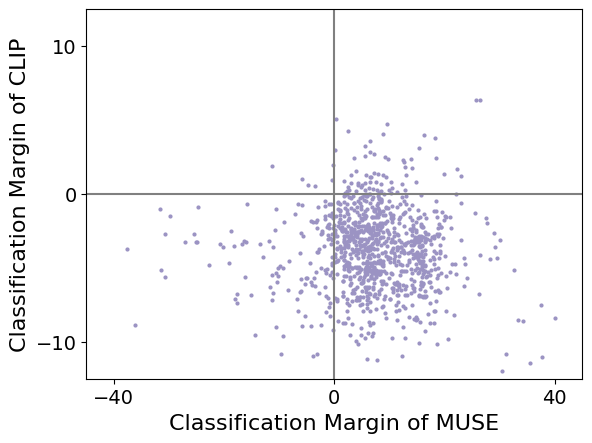

In [65]:
plt.scatter(best_sim_muse-worst_sim_muse,best_sim_clip-worst_sim_clip,s=4,c='#9B93C3')
plt.hlines(0,-45,45,color='gray')
plt.vlines(0,-12.5,12.5,color='gray')
plt.xlabel('Classification Margin of MUSE',fontsize=16)# max(cos($\hat{e}_V$,${e}_V^+$)) - max(cos($\hat{e}_V$,${e}_V^-$))')
plt.ylabel('Classification Margin of CLIP',fontsize=16)
plt.xlim(-45,45)
plt.ylim(-12.5,12.5)
plt.xticks([-40,0,40],fontsize=14)
plt.yticks([-10,0,10],fontsize=14)
plt.savefig("figs/classification_margins.pdf",bbox_inches='tight', pad_inches=0.2)

In [66]:
cm_muse = best_sim_muse-worst_sim_muse
cm_clip = best_sim_clip-worst_sim_clip
paths_np = np.array(paths)
muse_good = (cm_muse > 0) & (cm_clip < 0)
clip_good = (cm_muse < 0) & (cm_clip > 0)
both_good = (cm_muse > 0) & (cm_clip > 0)
both_bad = (cm_muse < 0) & (cm_clip < 0)


In [67]:
print('muse good:')
for p in paths_np[muse_good][:10]:
    print(p.split('/')[-1],end=', ')
print()
print('clip good:')
for p in paths_np[clip_good][:10]:
    print(p.split('/')[-1],end=', ')
print()
print('both good:')
for p in paths_np[both_good][:10]:
    print(p.split('/')[-1],end=', ')
print()
print('both bad:')
for p in paths_np[both_bad][:10]:
    print(p.split('/')[-1],end=', ')
print()

muse good:
O437346.jpg, O758401.jpg, O155069.jpg, O1156859.jpg, O473223.jpg, O48324.jpg, O96811.jpg, O1072466.jpg, O16111.jpg, O786735.jpg, 
clip good:
O26658.jpg, O363420.jpg, O1113625.jpg, O335395.jpg, O480103.jpg, O1109891.jpg, 
both good:
O87131.jpg, O87114.jpg, O141032.jpg, O249985.jpg, O353001.jpg, O133815.jpg, O319164.jpg, O4704.jpg, O21404.jpg, O79640.jpg, 
both bad:
O339776.jpg, O1722643.jpg, O206058.jpg, O228847.jpg, O1225473.jpg, O111621.jpg, O166910.jpg, O152961.jpg, O543468.jpg, O317125.jpg, 


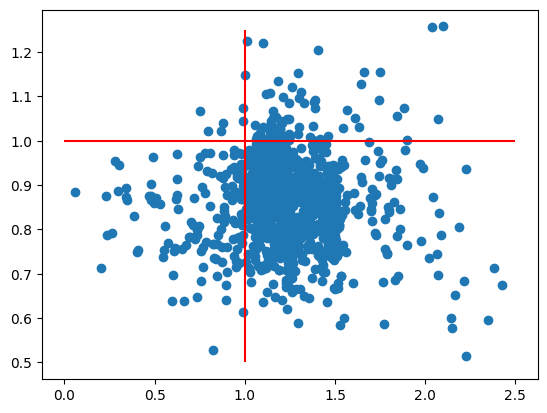

In [52]:
plt.scatter(best_sim_muse/worst_sim_muse,best_sim_clip/worst_sim_clip)
plt.hlines(1,0,2.5,color='r')
plt.vlines(1,0.5,1.25,color='r')

(0.0, 100.0)

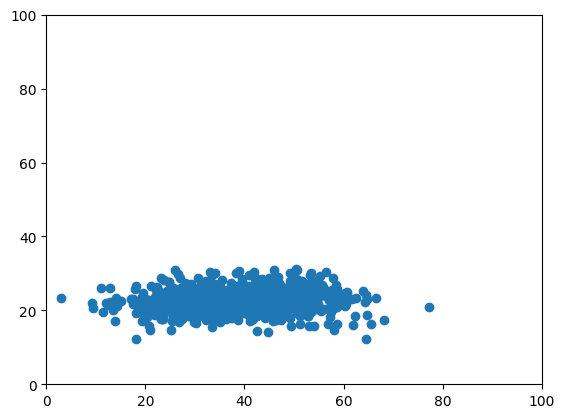

In [36]:
plt.scatter(best_sim_muse,best_sim_clip)
plt.xlim(0,100)
plt.ylim(0,100)

In [25]:
predicted_classes = []
for i in range(1024):
    curr_classes = []
    for idx in indices[i,:]:
        curr_classes.append(classnames[querries[i]][str(idx.item()+1)])
    predicted_classes.append(curr_classes)

predicted_classes_clip = []
for i in range(1024):
    curr_classes = []
    for idx in indices_clip[i,:]:
        curr_classes.append(classnames[querries[i]][str(idx.item()+1)])
    predicted_classes_clip.append(curr_classes)

In [26]:
target_classes = []
for i in range(1024):
    target_classes.append(attributes[i][key])

### Debugging

In [174]:
start_idx = 28

indexes = [start_idx + i for i in range(8)]
# Generate some sample images (replace this with your own image data)
images_to_plot = [Image.open(paths[i]) for i in indexes]

# Sample captions (replace these with your own captions)
# captions_to_plot = [f'Q: {querries[i]}? A: {classnames[querries[i]][str(labels[i].argmax().flatten().tolist()[0]+1)]}' for i in indexes]
captions_to_plot = [f'Q: {querries[i]}? A: {target_classes[i]}\nP: {predicted_classes[i]}' for i in indexes]

captions_to_plot

["Q: categories? A: ['ceramics', 'stoneware']\nP: ['ceramics', 'earthenware', 'stoneware', 'creamware', 'pottery']",
 "Q: categories? A: ['project', 'europeana', 'jewellery', 'fashion']\nP: ['jewellery', 'metalwork', 'footwear', 'ironwork', 'wear']",
 "Q: categories? A: ['sport', 'prints', 'posters']\nP: ['posters', 'advertising', 'postcards', 'prints', 'propaganda']",
 "Q: categories? A: ['photographs', 'va', 'history', 'architecture']\nP: ['photographs', 'photographic', 'architecture', 'properties', 'architectural']",
 "Q: categories? A: ['hardstone', 'vases', 'gemstones']\nP: ['hardstone', 'glass', 'vases', 'stoneware', 'ceramics']",
 "Q: categories? A: ['tools', 'arms', 'accessories', 'equipment', 'metalwork', 'armour']\nP: ['arms', 'armour', 'metalwork', 'ironwork', 'form']",
 "Q: categories? A: ['tools', 'household', 'objects', 'equipment', 'accessories']\nP: ['ceramics', 'earthenware', 'stoneware', 'pottery', 'creamware']",
 "Q: categories? A: ['children', 'toys', 'dolls', 'chil

In [43]:
def average_precision_per_class2(scores, targets:torch.Tensor, return_at_1=False):
    ap = torch.zeros(scores.size(1))
    ap1 = torch.zeros(scores.size(1))
    ap5 = torch.zeros(scores.size(1))
    ac5 = torch.zeros(scores.size(1))
    rg = torch.arange(1, scores.size(0) + 1).float()
    # compute average precision for each class
    batch_sz=2048
    for k in range((scores.size(1)-1)//batch_sz+1):
        # sort scores
        scores_k = scores[:, k*batch_sz:(k+1)*batch_sz]
        targets_k = targets[:, k*batch_sz:(k+1)*batch_sz]
        _, sortind = torch.sort(scores_k, 0, True)
        sortcol = torch.arange(0,sortind.shape[1]).repeat(sortind.shape[0],1)
        truth = targets_k[sortind,sortcol]
        tp = truth.float().cumsum(0)
        # compute precision curve
        precision = tp.div(rg.unsqueeze(1))
        # compute average precision
        ac5[k*batch_sz:(k+1)*batch_sz] = truth[:4,:].any(0).float()
        ap1[k*batch_sz:(k+1)*batch_sz] = precision[0,:]
        ap5[k*batch_sz:(k+1)*batch_sz] = precision[4,:]
        ap[k*batch_sz:(k+1)*batch_sz] = torch.where(truth.bool(),precision,torch.zeros_like(precision)).sum(0) / torch.clip((truth.sum(0)), min=1)
        # ap[k*batch_sz:(k+1)*batch_sz] = precision[truth.bool()].view_as(truth).sum(0) / torch.clip((truth.sum(0)), min=1)
    if return_at_1:
        return ap, ap1, ap5, ac5
    else:
        return ap


In [44]:
scores = average_precision_per_class2(pred,true,True)
print([sc.mean().item() for sc in scores])
scores = average_precision_per_class2(pred.T,true.T,True)
print([sc.mean().item() for sc in scores])

[0.06278719007968903, 0.06505421549081802, 0.04386989027261734, 0.088407002389431]
[0.5917167663574219, 0.6416015625, 0.16757814586162567, 0.7138671875]


In [45]:
scores = average_precision_per_class2(pred_clip,true,True)
print([sc.mean().item() for sc in scores])
scores = average_precision_per_class2(pred_clip.T,true.T,True)
print([sc.mean().item() for sc in scores])

[0.018020065501332283, 0.01751459576189518, 0.010842368938028812, 0.03169307857751846]
[0.10766717046499252, 0.03515625, 0.04257812350988388, 0.1669921875]


### Plotting

In [27]:
start_idx = 0

indexes = [start_idx + i for i in range(1024)]
# Generate some sample images (replace this with your own image data)
images_to_plot = [Image.open(paths[i]) for i in indexes]

# Sample captions (replace these with your own captions)
# captions_to_plot = [f'Q: {querries[i]}? A: {classnames[querries[i]][str(labels[i].argmax().flatten().tolist()[0]+1)]}' for i in indexes]
captions_to_plot = [f'{paths[i].split("/")[-1]}\nQ: {querries[i]}? A: {target_classes[i]}\nMUSE: {predicted_classes[i]}\nCLIP: {predicted_classes_clip[i]}' for i in indexes]

all_captions_to_plot[key] = captions_to_plot

for cp in captions_to_plot:
    print(cp)
    print()

O339776.jpg
Q: categories? A: ['unknown']
MUSE: ['ceramics', 'creamware', 'earthenware', 'pottery', 'stoneware']
CLIP: ['bronze', 'decorative', 'bone', 'britain', '2003']

O87131.jpg
Q: categories? A: ['caricatures', 'entertainment', '2003', 'leisure', 'drawings', 'cartoons', 'access_to_images']
MUSE: ['caricatures', 'cartoons', 'entertainment', 'leisure', 'studies']
CLIP: ['caricatures', 'ephemera', 'illustration', 'photograph', 'comic']

O1722643.jpg
Q: categories? A: ['stationery']
MUSE: ['unknown', 'accessories', 'east', 'medicine', 'work']
CLIP: ['china', 'chinese', 'va', 'inlay', '1994']

O87114.jpg
Q: categories? A: ['caricatures', 'entertainment', '2003', 'leisure', 'drawings', 'cartoons', 'access_to_images']
MUSE: ['caricatures', 'cartoons', 'studies', 'entertainment', 'drawings']
CLIP: ['caricatures', 'illustration', 'comic', 'ephemera', 'photograph']

O437346.jpg
Q: categories? A: ['ceramics', 'stoneware']
MUSE: ['ceramics', 'stoneware', 'earthenware', 'creamware', 'pottery'

In [272]:
for i in range(1024):
    print(all_captions_to_plot['materials'][i])
    print(all_captions_to_plot['categories'][i])
    print(all_captions_to_plot['techniques'][i])
    print(all_captions_to_plot['productionDates'][i])
    print()

O339776.jpg
Q: materials? A: ['fritware']
MUSE: ['fritware', 'plumbago', 'hyacinth', 'ultramarine', 'flax']
CLIP: ['jasper-agate', 'agate', 'fossilised', 'bowenite', 'variscite']
O339776.jpg
Q: categories? A: ['unknown']
MUSE: ['ceramics', 'creamware', 'earthenware', 'pottery', 'stoneware']
CLIP: ['bronze', 'decorative', 'bone', 'britain', '2003']
O339776.jpg
Q: techniques? A: ['lustre-painted']
MUSE: ['painted', 'glazed', 'sprayed', 'lustre-painted', 'stained']
CLIP: ['patinated', 'stone', 'ceramic', 'silk', 'underglaze']
O339776.jpg
Q: productionDates? A: ['12ndac-13rdac']
MUSE: ['1stac-13rdac', '13rdac-11stbc', '12ndac-13rdac', '3rdbc-13rdac', '11stac-13rdac']
CLIP: ['150bc', '1100bc', '520bc', '1800bc', '450bc']

O87131.jpg
Q: materials? A: ['paper', 'pencil']
MUSE: ['pencil', 'paper', 'pencils', 'papier', 'point-paper']
CLIP: ['book', 'ric', 'mori', 'eretmochelys', 'thuya']
O87131.jpg
Q: categories? A: ['caricatures', 'entertainment', '2003', 'leisure', 'drawings', 'cartoons', 'ac

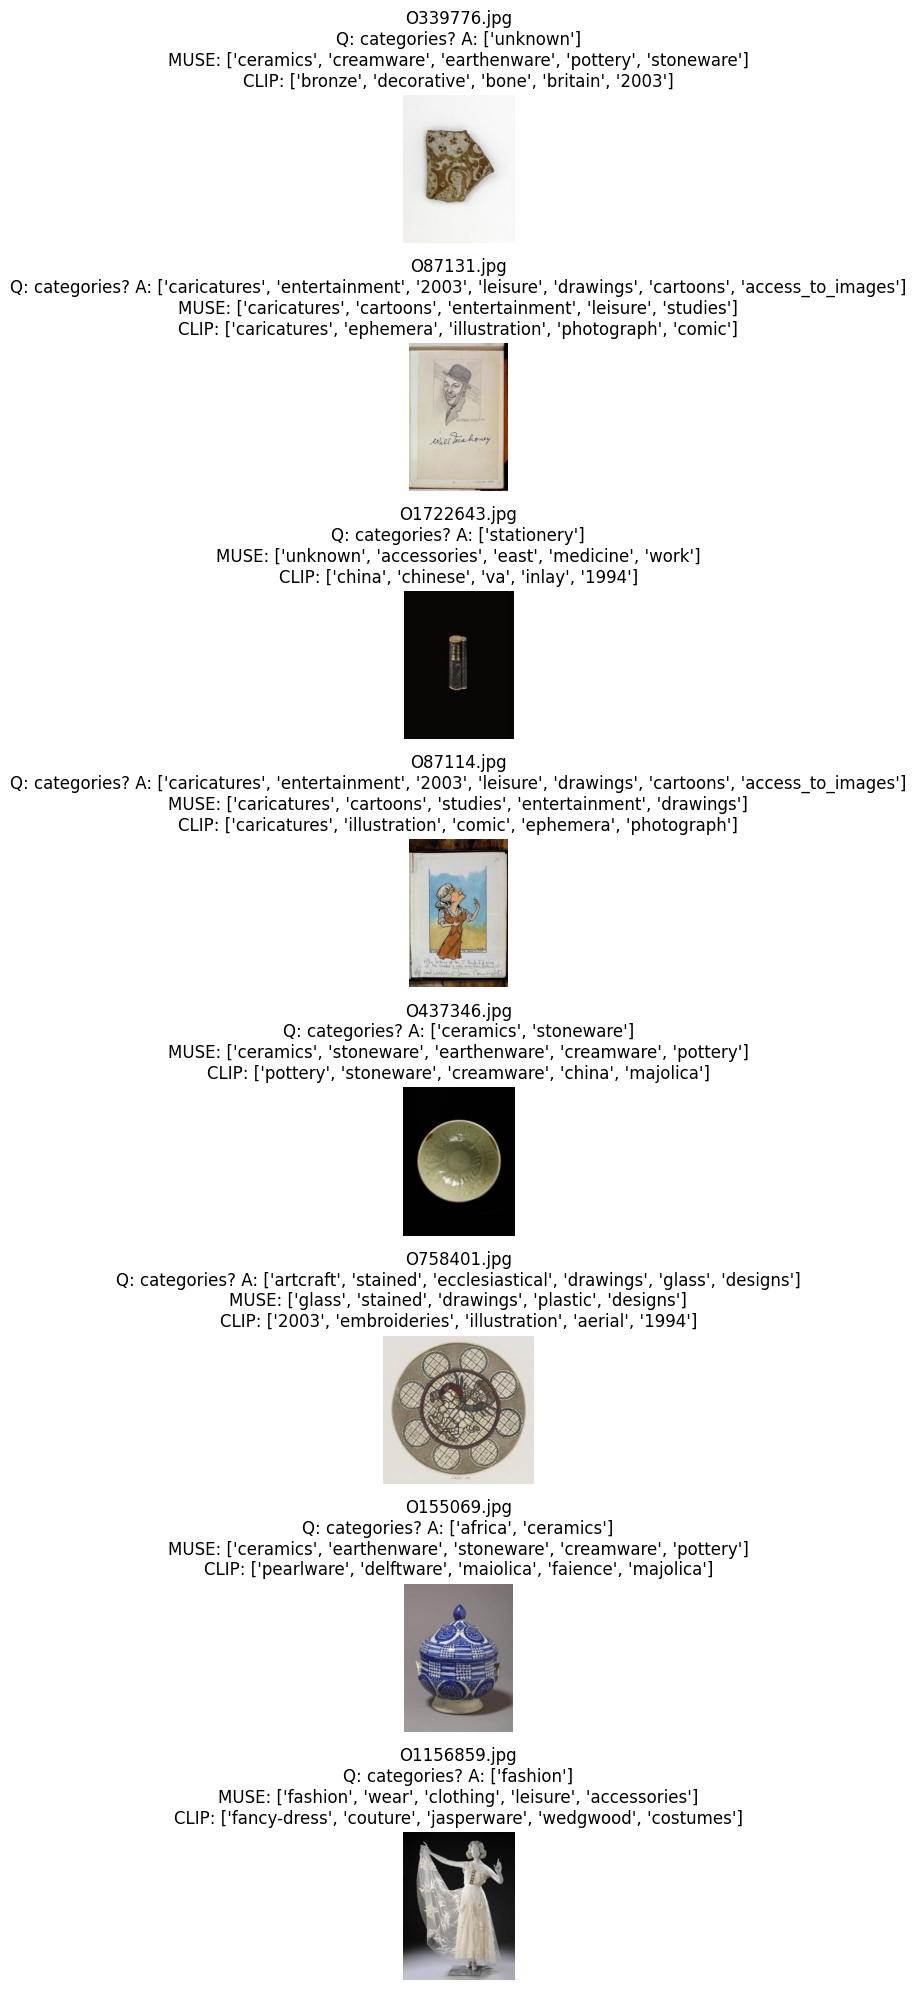

In [28]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(8, 1, figsize=(10, 20))

# Plot each image with its caption
for ax, img, caption in zip(axes.flat, images_to_plot, captions_to_plot):
    ax.imshow(img)
    ax.set_title(caption)
    ax.axis('off')

plt.tight_layout()
plt.show()
